<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/FoodViz_tinkering_v003_eff_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os

from PIL import Image
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Device agnostic code

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data from the drive (local):

train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

### EfficientNet_B0 ###

In [4]:
# Load EfficientNet with B0 pretrained weights

weights_eff = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model_eff = models.efficientnet_b0(weights=weights_eff)
preprocess_eff = weights_eff.transforms()

In [5]:
# Use the preprocess transform for EfficientNet_B0 (preprocess_eff) and set up train/test dataset(s) and dataloader(s) from img directory;

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess_eff
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess_eff
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=2
)

In [6]:
#  EfficientNet_B0 model, class, device, criterion & optimizer instantiation;

# Number of classes in Pizza–Steak–Sushi
num_classes = len(train_dataset.classes)  # should be 3

# Use EfficientNet_B0 backbone
model = model_eff

# Freeze all layers except the final classifier head
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer w/ the num_classes from the foodnet dataset --> EfficientNet uses model.classifier
model.classifier = nn.Linear(
      in_features=model.classifier[1].in_features
      , out_features=num_classes
)

# Move to device (device agnostic code should have already been run early in nb;)
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
      model.classifier.parameters()
      , lr=1e-3
)

In [8]:
# EfficientNet_B0 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

# Lists to store metrics over epochs
train_losses = []
train_accuracies = []

# Since we already know it works well, just going with 20 epochs;)
epochs = 20

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    # Compute metrics for this epoch
    train_loss = running_loss / total
    train_acc = correct / total * 100

    # Save metrics (so we can plot a loss/acc curve!)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}%")

  5%|██▎                                           | 1/20 [00:15<04:45, 15.00s/it]

Epoch 1/20 | Loss: 0.8358 | Acc: 67.1111%


 10%|████▌                                         | 2/20 [00:29<04:20, 14.47s/it]

Epoch 2/20 | Loss: 0.6995 | Acc: 79.5556%


 15%|██████▉                                       | 3/20 [00:42<04:01, 14.20s/it]

Epoch 3/20 | Loss: 0.6117 | Acc: 78.6667%


 20%|█████████▏                                    | 4/20 [00:57<03:48, 14.30s/it]

Epoch 4/20 | Loss: 0.5254 | Acc: 88.0000%


 25%|███████████▌                                  | 5/20 [01:11<03:31, 14.08s/it]

Epoch 5/20 | Loss: 0.4652 | Acc: 89.3333%


 30%|█████████████▊                                | 6/20 [01:24<03:14, 13.92s/it]

Epoch 6/20 | Loss: 0.4167 | Acc: 92.8889%


 35%|████████████████                              | 7/20 [01:39<03:04, 14.20s/it]

Epoch 7/20 | Loss: 0.3740 | Acc: 95.1111%


 40%|██████████████████▍                           | 8/20 [01:53<02:48, 14.08s/it]

Epoch 8/20 | Loss: 0.3800 | Acc: 94.6667%


 45%|████████████████████▋                         | 9/20 [02:07<02:34, 14.01s/it]

Epoch 9/20 | Loss: 0.3652 | Acc: 92.4444%


 50%|██████████████████████▌                      | 10/20 [02:20<02:18, 13.85s/it]

Epoch 10/20 | Loss: 0.3362 | Acc: 95.1111%


 55%|████████████████████████▊                    | 11/20 [02:34<02:03, 13.77s/it]

Epoch 11/20 | Loss: 0.3216 | Acc: 93.3333%


 60%|███████████████████████████                  | 12/20 [02:47<01:49, 13.66s/it]

Epoch 12/20 | Loss: 0.3085 | Acc: 93.7778%


 65%|█████████████████████████████▎               | 13/20 [03:01<01:36, 13.71s/it]

Epoch 13/20 | Loss: 0.2671 | Acc: 97.3333%


 70%|███████████████████████████████▍             | 14/20 [03:15<01:22, 13.80s/it]

Epoch 14/20 | Loss: 0.2618 | Acc: 96.0000%


 75%|█████████████████████████████████▊           | 15/20 [03:29<01:09, 13.88s/it]

Epoch 15/20 | Loss: 0.2701 | Acc: 94.6667%


 80%|████████████████████████████████████         | 16/20 [03:43<00:55, 13.93s/it]

Epoch 16/20 | Loss: 0.2395 | Acc: 98.2222%


 85%|██████████████████████████████████████▎      | 17/20 [03:58<00:42, 14.25s/it]

Epoch 17/20 | Loss: 0.2391 | Acc: 95.1111%


 90%|████████████████████████████████████████▌    | 18/20 [04:12<00:28, 14.17s/it]

Epoch 18/20 | Loss: 0.2051 | Acc: 97.7778%


 95%|██████████████████████████████████████████▊  | 19/20 [04:26<00:14, 14.12s/it]

Epoch 19/20 | Loss: 0.2195 | Acc: 96.4444%


100%|█████████████████████████████████████████████| 20/20 [04:41<00:00, 14.06s/it]

Epoch 20/20 | Loss: 0.2125 | Acc: 97.3333%


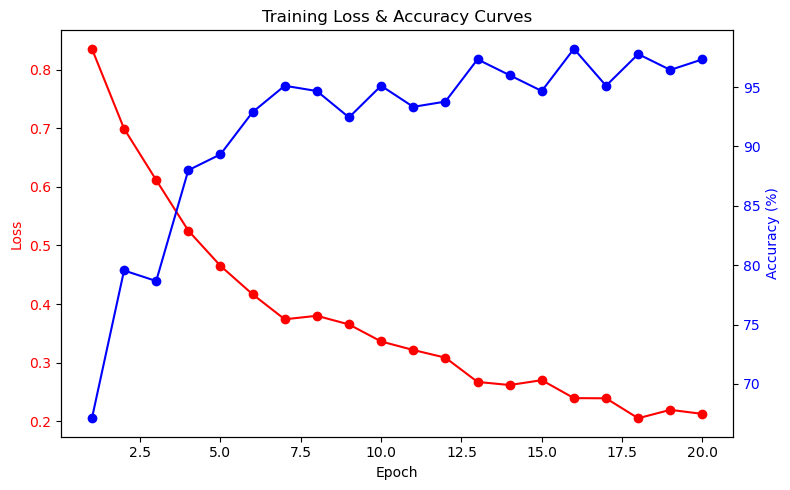

In [9]:
# --------------------------
# Plot Loss & Accuracy
# --------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot loss on left y-axis
ax1.plot(range(1, epochs+1), train_losses, color='red', marker='o', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), train_accuracies, color='blue', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title('Training Loss & Accuracy Curves')
fig.tight_layout()
plt.show();

In [10]:
# Running Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 88.0000%


In [11]:
model.classifier

Linear(in_features=1280, out_features=3, bias=True)

In [12]:
train_acc, train_loss

(97.33333333333334, 0.2125111002392239)

***Save trained model***

In [20]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)  # creates it if it doesn't exist

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")
model_save_path = os.path.join(save_dir, f"efficientnet_b0_pizza_steak_sushi_{current_date}.pth")

In [22]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: saved_models/efficientnet_b0_pizza_steak_sushi_20251020.pth


In [23]:
import os
from PIL import Image
import torch
from torchvision import models

# Folder containing unseen images (these are images of pizza/ steak/ sushi randomly grabbed fm the internet;)
folder_path = "./data/unseen_pza_stk_ssh"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Preprocessing used for EfficientNet_B0
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Class names (same as your dataset)
class_names = ["pizza", "steak", "sushi"]

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

In [14]:
# Actual predix on unseen imgs:

predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

sushi_003.jpeg → Predicted: sushi
sushi_002.jpeg → Predicted: sushi
pizza_001.jpeg → Predicted: pizza
steak_001.jpeg → Predicted: steak
steak_003.jpeg → Predicted: steak
steak_002.jpeg → Predicted: steak
sushi_001.jpeg → Predicted: sushi
pizza_002.jpeg → Predicted: pizza
pizza_003.jpeg → Predicted: pizza


In [15]:
# Extract true labels from filenames
true_labels = [f.split("_")[0] for f in image_files]
print(true_labels)

['sushi', 'sushi', 'pizza', 'steak', 'steak', 'steak', 'sushi', 'pizza', 'pizza']


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support

       pizza       1.00      1.00      1.00         3
       steak       1.00      1.00      1.00         3
       sushi       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix:

[[3 0 0]
 [0 3 0]
 [0 0 3]]


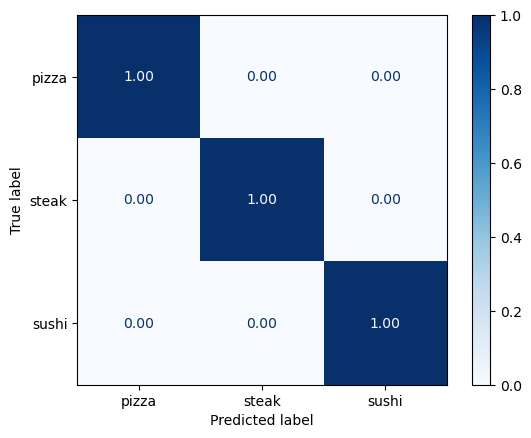

In [17]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [18]:
import os
from PIL import Image
import torch
from torchvision import models
from matplotlib import pyplot as plt

In [24]:
def show_image_prediction(img_path):
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_class = class_names[probabilities.argmax()]

    # Display with matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class}", fontsize=14, color='green')
    plt.show();

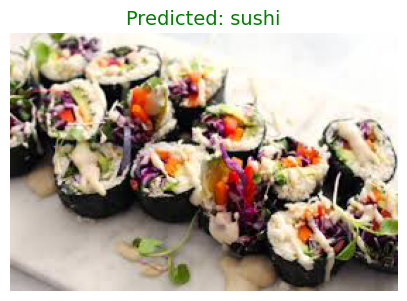

In [26]:
show_image_prediction(os.path.join(folder_path, image_files[0]))

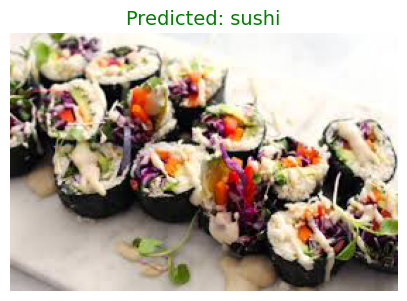

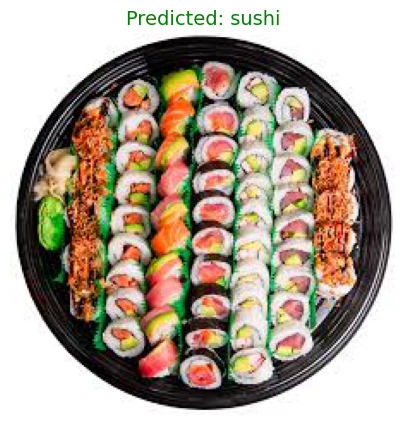

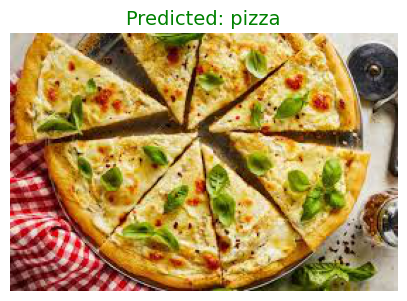

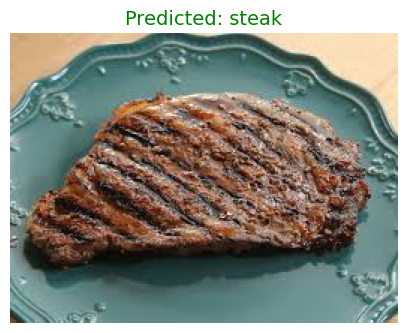

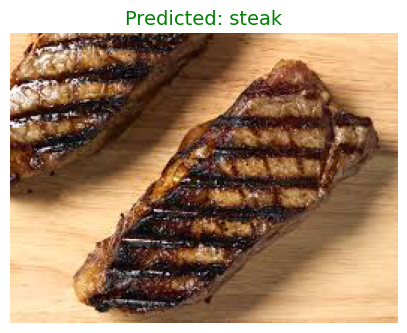

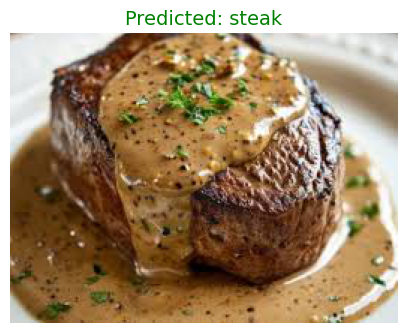

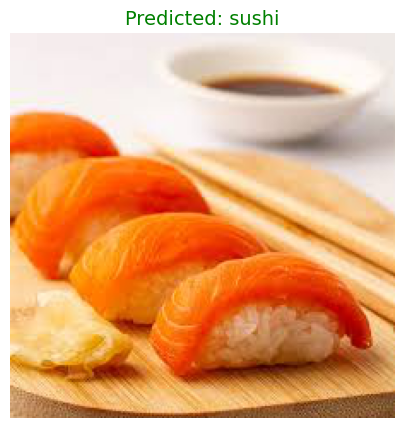

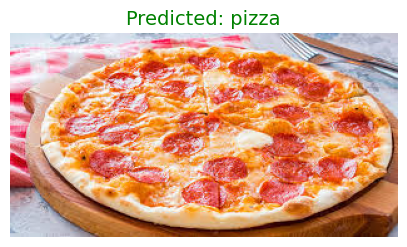

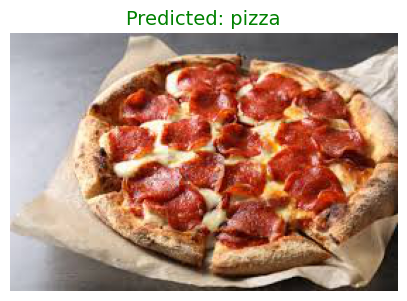

In [27]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

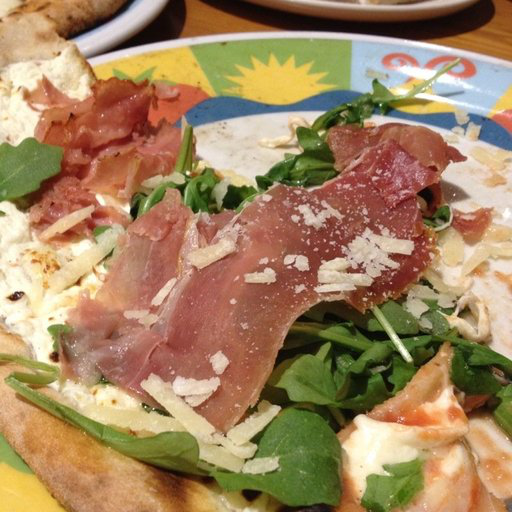

In [28]:
img_ = Image.open('./data/pizza_steak_sushi/train/pizza/1105700.jpg').convert("RGB")
img_

In [ ]:
# Viewing shapes of random imgs from the transformed dataset:

In [28]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


In [29]:
images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 23
single image shape: torch.Size([3, 224, 224])
single label: 0


In [30]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 224, 224])
label: 2
